## @copyright:Rahul Kumar (RK), 2022, CICbiomaGUNE, MF&B

The notebook contains the code for the automatic segmentation of pulmonary artery using 3D-Unet architecture. This is adapted from Monai's Unet Architecture but can be tweaked to our personal needs.

Information about the GPU resources

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun  6 14:18:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive/DeepSeg/')
print(os.getcwd())

/content/drive/MyDrive/DeepSeg




#Install packages

In [4]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 19.2 MB/s eta 0:00:00


## Import essential monai modules and transforms

In [5]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
#from monai.handlers.utils import from_engine
from unet import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob


In [6]:
print_config()

MONAI version: 1.2.dev2323
Numpy version: 1.22.4
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: f65df68bce45749a71b36c79f003b72c80982bbe
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.12.2
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-r

Seed is used to ensure reproducibility

In [7]:
set_determinism(seed=0)

In [8]:
from pathlib import Path
from datetime import datetime

In [9]:
# Dataset
dataset_url = 'https://www.dropbox.com/s/rn6sgm0emex5s73/PH.zip?dl=0'
#dataset_url = 'https://www.dropbox.com/s/0dktel33zcsv1wx/PH_New.zip?dl=0'
dataset_path = 'PH.zip'
#dataset_path = 'PH_New.zip'
dataset_dir_name = 'PH'
#dataset_dir_name = 'PH_New'
dataset_dir = Path(dataset_dir_name)
histogram_landmarks_path = 'landmarks.npy'
print(dataset_dir)






PH


In [10]:
!apt-get -qq install tree

Selecting previously unselected package tree.
(Reading database ... 122542 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...
Processing triggers for man-db (2.9.1-1) ...


In [11]:
if not dataset_dir.is_dir():
    !curl --silent --output {dataset_path} --location {dataset_url} 
    !unzip -qq {dataset_path}
!tree -d {dataset_dir_name}

PH
├── Images
└── Labels

2 directories


In [12]:
#Datasets nifti stuff,
images_dir = dataset_dir /'Images'
labels_dir = dataset_dir /'Labels'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
assert len(image_paths) == len(label_paths)
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(image_paths, label_paths)
]
train_files, val_files = data_dicts[:-8], data_dicts[-8:]    


Transform is the way to augment the datasets. Since we have lesser data, augmentation is needed to prevent the overfitting

In [13]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            2.5, 2.5, 2.5), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
   
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            2.5, 2.5, 2.5), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


image shape: torch.Size([120, 120, 128]), label shape: torch.Size([120, 120, 128])


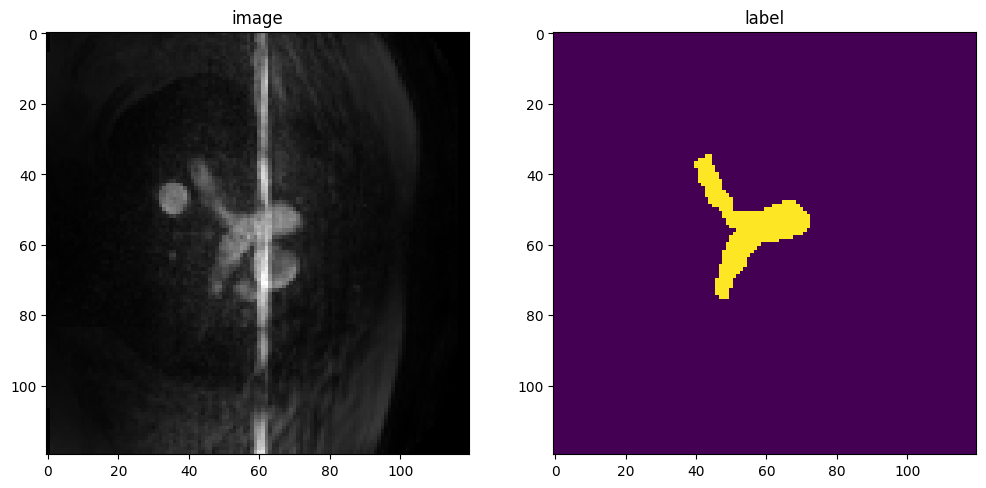

In [23]:

# Create the Dataset and DataLoader
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)

# Get the first data from the DataLoader
check_data = next(iter(check_loader))
image, label = check_data["image"][0][0], check_data["label"][0][0]

# Print the shapes of the image and label tensors
print(f"image shape: {image.shape}, label shape: {label.shape}")

# Plot the slice
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 82], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 82])
plt.show()

In [15]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 8/8 [00:00<00:00,  9.25it/s]


# Typical  PyTorch program style: Create UNet, DiceLoss and Adam optimizer

In [16]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [17]:
directory = os.environ.get("PH")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpn74ered5


In [32]:
max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])
dice_metric = DiceMetric(include_background=True, reduction="mean")

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for step, batch_data in enumerate(train_loader, 1):
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")


----------
epoch 1/100
1/5, train_loss: 0.2945
2/5, train_loss: 0.3151
3/5, train_loss: 0.2816
4/5, train_loss: 0.2841
5/5, train_loss: 0.2670
6/5, train_loss: 0.2533
epoch 1 average loss: 0.2826
----------
epoch 2/100
1/5, train_loss: 0.2633
2/5, train_loss: 0.2505
3/5, train_loss: 0.3191
4/5, train_loss: 0.2877
5/5, train_loss: 0.2782
6/5, train_loss: 0.2786
epoch 2 average loss: 0.2796
saved new best metric model
current epoch: 2 current mean dice: 0.8073
best mean dice: 0.8073 at epoch: 2
----------
epoch 3/100
1/5, train_loss: 0.2805
2/5, train_loss: 0.2761
3/5, train_loss: 0.2377
4/5, train_loss: 0.2911
5/5, train_loss: 0.2776
6/5, train_loss: 0.2405
epoch 3 average loss: 0.2673
----------
epoch 4/100
1/5, train_loss: 0.2781
2/5, train_loss: 0.2773
3/5, train_loss: 0.2472
4/5, train_loss: 0.2682
5/5, train_loss: 0.2680
6/5, train_loss: 0.2610
epoch 4 average loss: 0.2667
current epoch: 4 current mean dice: 0.7934
best mean dice: 0.8073 at epoch: 2
----------
epoch 5/100
1/5, trai

In [33]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")


train completed, best_metric: 0.8417 at epoch: 74


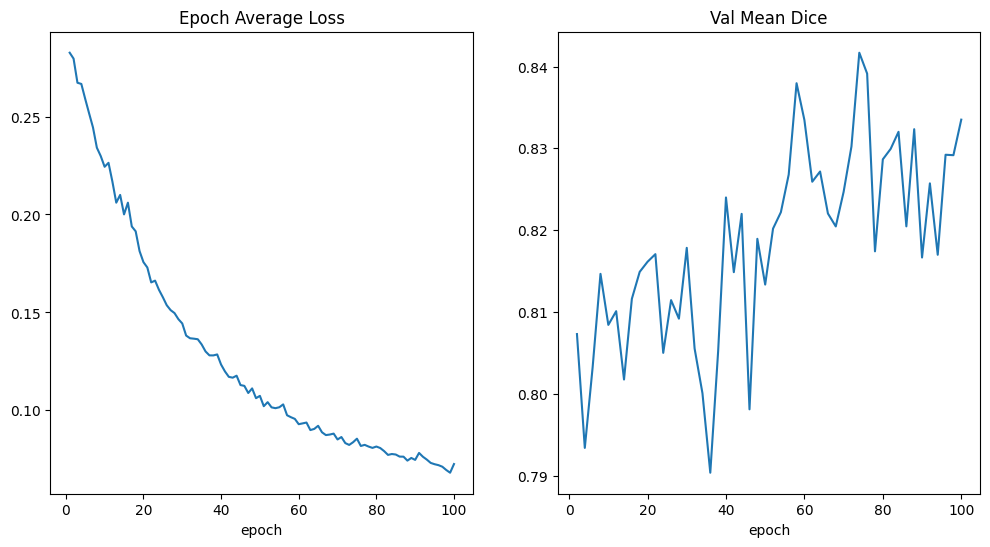

In [34]:
plt.figure("train", (12, 6))

# Plot Epoch Average Loss
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = range(1, len(epoch_loss_values) + 1)
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)

# Plot Val Mean Dice
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = range(val_interval, (len(metric_values) + 1) * val_interval, val_interval)
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()


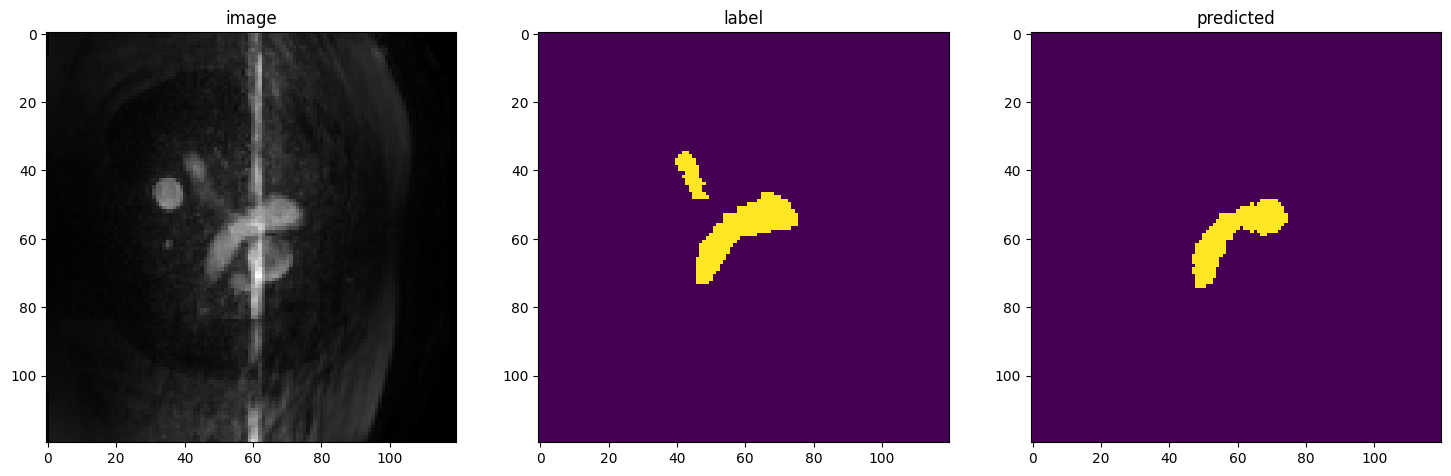

In [35]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    check_data = next(iter(val_loader))
    roi_size = (128, 128, 128)
    sw_batch_size = 4
    val_outputs = sliding_window_inference(check_data["image"].to(device), roi_size, sw_batch_size, model)
    
    image = check_data["image"][0, 0, :, :, 80]
    label = check_data["label"][0, 0, :, :, 80]
    predicted = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80]

    # Plot the slice [:, :, 80]
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(image, cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(label)

    plt.subplot(1, 3, 3)
    plt.title("predicted")
    plt.imshow(predicted)

    plt.show()


In [ ]:
# Not bad